In [ ]:
# 1) (Optional) Installs — uncomment on first run
# !pip install -U matplotlib timm torchvision torch tqdm scikit-learn --quiet
!pip install -U open-clip-torch torchinfo --quiet
print('If you need packages, uncomment the pip lines above and run this cell.')

If you need packages, uncomment the pip lines above and run this cell.


In [ ]:
# 2) Common imports + seeds
import math, random, os, time
from dataclasses import dataclass
from typing import Tuple, List

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import transforms

import torchinfo

import datasets

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import open_clip

def set_seed(seed:int=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False

set_seed(123)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device is {device}")

Device is cuda


In [ ]:
from dataclasses import dataclass
from typing import Tuple

# Pick a lightweight variant for quick experiments


@dataclass
class Config:
    #model_name: str = "ViT-B-32"  # new MobileCLIP2 in open_clip
    #pretrained: str = "laion2b_s34b_b79k"
    model_name = 'MobileCLIP2-S0'   # alternatives: 'MobileCLIP2-S2', 'MobileCLIP2-B', 'MobileCLIP2-S3', 'MobileCLIP2-S4', 'MobileCLIP2-L-14'
    pretrained = 'dfndr2b'          # per MobileCLIP2 release in OpenCLIP

    dataset = 'eurosat'

    coop_prompt_save_path = 's0_coop_eurosat.pt'

    image_size: int = 224
    batch_size: int = 64
    num_workers: int = 4
    max_epochs: int = 300

    # LR split: base vs prompt
    lr_base: float = 1e-5
    lr_prompt: float = 1e-4
    weight_decay: float = 0.05

    # Unfreeze (if you want a light finetune on top of prompt)
    unfreeze_layers: Tuple[str, ...] = tuple()  # e.g. ("visual.transformer.resblocks.11",)

    # CoOp prompt length
    prompt_len: int = 16
    fewshot_k: int = 16

    # Overfit sanity tiny subset
    overfit_n_classes: int = 2
    overfit_k_per_class: int = 8
    overfit_epochs: int = 50


cfg = Config()
cfg


Config(image_size=224, batch_size=64, num_workers=4, max_epochs=300, lr_base=1e-05, lr_prompt=0.0001, weight_decay=0.05, unfreeze_layers=(), prompt_len=16, fewshot_k=16, overfit_n_classes=2, overfit_k_per_class=8, overfit_epochs=50)

In [ ]:
# --- Load model + preprocess ---
clip_model, _, preprocess = open_clip.create_model_and_transforms(cfg.model_name, pretrained=cfg.pretrained)
tokenizer = open_clip.get_tokenizer(cfg.model_name)

torchinfo.summary(clip_model)

Layer (type:depth-idx)                                                           Param #
CustomTextCLIP                                                                   1
├─TimmModel: 1-1                                                                 --
│    └─FastVit: 2-1                                                              --
│    │    └─Sequential: 3-1                                                      7,424
│    │    └─Sequential: 3-2                                                      10,728,256
│    │    └─MobileOneBlock: 3-3                                                  146,496
│    │    └─ClassifierHead: 3-4                                                  524,800
│    └─Sequential: 2-2                                                           --
├─TextTransformer: 1-2                                                           301,568
│    └─Embedding: 2-3                                                            25,296,896
│    └─Transformer: 2-4               

In [ ]:
#full_train_ds = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=preprocess)
#full_train_size = len(full_train_ds)
#val_size = int(full_train_size * 0.02)
#
#train_ds, val_ds = torch.utils.data.random_split(full_train_ds, [full_train_size - val_size, val_size])
#overfit_train_ds, overfit_val_ds, _ = torch.utils.data.random_split(full_train_ds, [16, 16, full_train_size - 32])
#
#train_loader = DataLoader(train_ds, batch_size=128, shuffle=False, num_workers=2)
#val_loader = DataLoader(val_ds, batch_size=128, shuffle=False, num_workers=2)
#
#overfit_train_loader = DataLoader(overfit_train_ds, batch_size=128, shuffle=False, num_workers=0)
#overfit_val_loader = DataLoader(overfit_val_ds, batch_size=128, shuffle=False, num_workers=0)
#
#classnames = full_train_ds.classes
#num_classes = len(classnames)
#
#print(f"Val dataset:   {len(val_ds)} images, {num_classes} classes")
#
#def show_batch(dl: DataLoader, rows: int=2, cols: int=8):
#    batch = next(iter(dl))
#    images, labels = batch
#    fig, axs = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
#    for i in range(rows):
#        for j in range(cols):
#            idx = i*cols + j
#            if idx >= len(images):
#                break
#            img = images[idx].permute(1, 2, 0).cpu().numpy()
#            label = classnames[labels[idx]]
#            axs[i, j].imshow(img)
#            axs[i, j].set_title(label)
#            axs[i, j].axis('off')
#    plt.tight_layout()
#    plt.show()
#
#show_batch(val_loader, rows=2, cols=8)

ClassLabel(names=['annual crop', 'forest', 'herbaceous vegetation', 'highway', 'industrial', 'pasture', 'permanent crop', 'residential', 'river', 'sea or lake'])
Val dataset:   2700 images, 10 classes


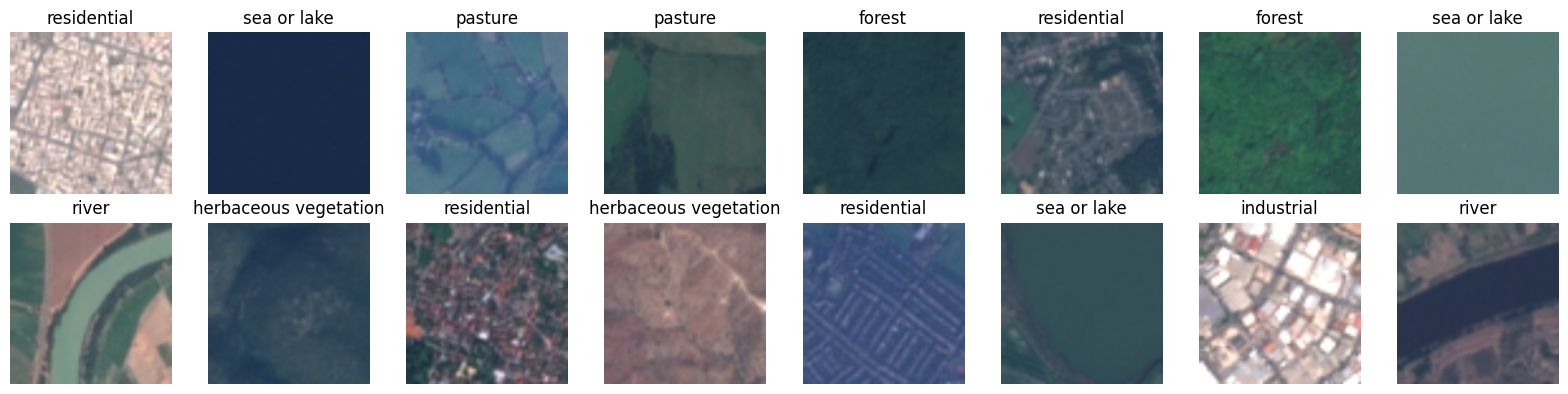

In [ ]:
from datasets import DatasetDict

full_ds = datasets.load_dataset(
    "jonathan-roberts1/EuroSAT",
    cache_dir="./hf_data",
)
full_train_ds = full_ds["train"]
splits = full_train_ds.train_test_split(test_size=0.1)
full_ds = DatasetDict({
    "train": splits["train"],
    "validation": splits["test"]
})
train_ds = full_ds["train"]
val_ds = full_ds["validation"]
#test_ds = full_ds["test"]

def transform(batch):
    imgs = [img.convert("RGB") for img in batch["image"]]
    batch["pixel_values"] = [preprocess(img) for img in imgs]
    return batch

train_ds = train_ds.with_transform(transform)
val_ds   = val_ds.with_transform(transform)
#test_ds = test_ds.with_transform(transform)

def collate_fn(batch):
    images = torch.stack([b["pixel_values"] for b in batch])  # [B,3,H,W]
    labels = torch.tensor([b["label"] for b in batch])       # [B]
    return images, labels

train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False, collate_fn=collate_fn)
#train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=False, collate_fn=collate_fn)

print(train_ds.features["label"])
label_feature = train_ds.features["label"]
classnames = label_feature.names
num_classes = label_feature.num_classes

print(f"Val dataset:   {len(val_ds)} images, {num_classes} classes")

def show_batch(dl: DataLoader, rows: int=2, cols: int=8):
    batch = next(iter(dl))
    images, labels = batch
    fig, axs = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i in range(rows):
        for j in range(cols):
            idx = i*cols + j
            if idx >= len(images):
                break
            img = images[idx].permute(1, 2, 0).cpu().numpy()
            label = classnames[labels[idx]]
            axs[i, j].imshow(img)
            axs[i, j].set_title(label)
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

show_batch(val_loader, rows=2, cols=8)

In [ ]:
from collections import defaultdict

def get_fewshot_dataloader(dl, k, *, label_col="label", seed=42):
    ds = dl.dataset
    #orig_tf = getattr(ds, "_transform", None)          # remember HF transform (if any)
    #base = ds.with_transform(None)                     # disable during index selection
    print(ds)

    # collect indices per class (HF: fast column access)
    idx_by_label = defaultdict(list)
    for i, batch in enumerate(ds):
        y = batch[label_col]
        idx_by_label[y].append(i)

    # choose up to k per class, then shuffle globally
    rng = random.Random(seed)
    selected = []
    for idxs in idx_by_label.values():
        rng.shuffle(idxs)
        selected.extend(idxs[:k])
    rng.shuffle(selected)

    subset = ds.select(selected)
    #if orig_tf is not None:
    #    subset = subset.with_transform(orig_tf)

    # rebuild a DataLoader reusing the original settings
    return DataLoader(
        subset,
        batch_size=dl.batch_size or 1,
        shuffle=False,                 # we already shuffled indices
        collate_fn=dl.collate_fn,
        num_workers=dl.num_workers,
        pin_memory=getattr(dl, "pin_memory", False),
        drop_last=getattr(dl, "drop_last", False),
        persistent_workers=getattr(dl, "persistent_workers", False),
    )

In [ ]:
class HardcodedPrompt(nn.Module):
    def __init__(self, clip, classnames):
        super().__init__()
        #text_tower = getattr(clip, "text", clip)
        prompts = [f"a photo of a {c}" for c in classnames]
        ## Bad practice to use .to(device) in here, make sure it's a registered buffer
        text_tokens = tokenizer(prompts).to(device)
        text_features = clip.encode_text(text_tokens)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        self.register_buffer("text_features", text_features)

    def forward_text_features(self):
        return self.text_features

In [ ]:
class ZeroShotClassifier(nn.Module):
    def __init__(self, clip, hardcoded_prompt):
        super().__init__()
        self.clip = clip
        self.hardcoded_prompt = hardcoded_prompt

    def forward(self, images):
        with torch.no_grad():
            image_features = self.clip.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = self.hardcoded_prompt.forward_text_features()
            logits = 100.0 * image_features @ text_features.T
        return logits

In [ ]:
class CoOpPrompt(nn.Module):
    def __init__(self, clip, tokenizer, classnames, n_ctx=16, init_scale=0.02):
        super().__init__()
        self.clip = clip
        self.text_tower = getattr(self.clip, "text", self.clip)
        #self.visual_tower = getattr(self.model, "visual", self.model)
        self.tokenizer = tokenizer
        self.classnames = classnames

        # Text transformer sizes
        self.context_length = getattr(self.text_tower, "context_length", 77)
        self.width = self.text_tower.token_embedding.weight.shape[1] # 512

        # Learnable context (n_ctx continuous "tokens")
        self.ctx = nn.Parameter(init_scale * torch.randn(n_ctx, self.width))

        # Tokenize bare classnames (we'll prepend soft context ourselves)
        with torch.no_grad():
            self.register_buffer('class_token_ids', tokenizer(classnames)) # [C, L]
            # EOT trick: in CLIP tokenization the EOT id is the largest id in each row
            self.register_buffer('eot_indices', self.class_token_ids.argmax(dim=-1))

        # Freeze CLIP
        for p in self.text_tower.parameters():
            p.requires_grad = False
        for p in self.clip.parameters():
            p.requires_grad = False

    def train(self, mode=True):
        super().train(mode)
        if mode:
          self.clip.eval()
          self.text_tower.train()
        else:
          self.clip.eval()
          self.text_tower.eval()

    def forward_text_features(self):
        C = len(self.classnames)
        token_ids = self.class_token_ids  # [C, L]

        # Frozen lookup for class tokens
        with torch.no_grad():
            tok_emb = self.text_tower.token_embedding(token_ids)  # [C, L, W]

        sos = tok_emb[:, :1, :]         # [C,1,W]
        class_part = tok_emb[:, 1:, :]  # [C,L-1,W]

        # Learnable context repeated across classes
        ctx = self.ctx.unsqueeze(0).expand(C, -1, -1)  # [C, n_ctx, W]

        # [SOS] + [CTX...CTX] + [class tokens...]
        x = torch.cat([sos, ctx, class_part], dim=1)  # [C, 1+n_ctx+(L-1), W]

        # Pad/truncate to model context length
        L_target = getattr(self.text_tower, "context_length", 77)
        if x.size(1) > L_target:
            x = x[:, :L_target, :]
        elif x.size(1) < L_target:
            pad_len = L_target - x.size(1)
            pad = x.new_zeros(C, pad_len, x.size(2))
            x = torch.cat([x, pad], dim=1)
        L = x.size(1)

        # Dtypes, pos emb, and (optional) attn mask, all sliced to L
        text_dtype = self.text_tower.token_embedding.weight.dtype
        pos = self.text_tower.positional_embedding[:L].to(text_dtype)  # [L,W]

        attn = getattr(self.text_tower, "attn_mask", None)
        if attn is not None:
            attn = attn[:L, :L].to(text_dtype)  # ensure (L,L)

        # Respect transformer.batch_first
        batch_first = getattr(self.text_tower.transformer, "batch_first", False)
        if batch_first:
            # want [N, L, D]
            x = x.to(text_dtype) + pos.unsqueeze(0)   # [C,L,W]
            x = self.text_tower.transformer(x, attn_mask=attn)  # stays [C,L,W]
            x = self.text_tower.ln_final(x).to(text_dtype)      # [C,L,W]
        else:
            # want [L, N, D]
            x = (x.to(text_dtype) + pos).permute(1, 0, 2)  # [L,C,W]
            x = self.text_tower.transformer(x, attn_mask=attn)  # [L,C,W]
            x = x.permute(1, 0, 2)                         # [C,L,W]
            x = self.text_tower.ln_final(x).to(text_dtype)      # [C,L,W]

        # Pool at EOT (shift by n_ctx), clamp in case of truncation
        eot = (self.eot_indices + self.ctx.shape[0]).clamp(max=L - 1)
        text_emb = x[torch.arange(C, device=eot.device), eot] @ self.text_tower.text_projection  # [C,D]

        # Normalize
        text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
        return text_emb

In [ ]:
class CoOpClip(nn.Module):
    def __init__(self, clip, coop_prompt):
        super().__init__()
        self.clip = clip
        self.coop_prompt = coop_prompt

        self.clip.requires_grad_(False)
        self.coop_prompt.requires_grad_(True)

    def train(self, mode: bool=True):
        super().train(mode)
        if mode:
          self.clip.eval()
          self.coop_prompt.train()
        else:
          self.clip.eval()
          self.coop_prompt.eval()

    def forward(self, images):
        images = images.to(device)
        with torch.no_grad():
            image_features = self.clip.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = self.coop_prompt.forward_text_features()
        logits = 100.0 * image_features @ text_features.T
        return logits

In [ ]:
def accuracy(logits, labels):
    preds = logits.argmax(dim=-1)
    correct = (preds == labels).float().mean().item()
    return correct

In [ ]:
@torch.no_grad()
def evaluate_classifier(model, test_loader, loss_fn, device, desc="eval", pbar=True):
  model.eval()
  loss_sum, correct, count = 0.0, 0, 0
  iterator = tqdm(test_loader, desc=desc, leave=False) if pbar else test_loader
  for images, labels in iterator:
    images = images.to(device, non_blocking=True)
    labels = labels.to(device, non_blocking=True)
    logits = model(images)
    loss = loss_fn(logits, labels)

    bs = labels.size(0)
    loss_sum += loss.item() * bs
    preds = logits.argmax(dim=1)
    correct += (preds == labels).sum().item()
    count += bs

    if pbar:
      acc = (correct / max(1, count)) * 100.0
      iterator.set_postfix(loss=loss.item(), acc=f"{acc:.2f}%")

  avg_loss = loss_sum / max(1, count)
  avg_acc = correct / max(1, count)
  return avg_loss, avg_acc

def train(
    model, train_loader, val_loader, device="cpu",
    epochs=5, batch_size=256, lr=5e-3, log_train_interval=25, log_val_interval=None
):
    model.to(device)

    print(model.coop_prompt.parameters())
    optimizer = torch.optim.AdamW([model.coop_prompt.ctx], lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    t = 0 # current_time_step
    # Todo add batches per epoch

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_time': [], 'val_time': []
    }

    model.eval()
    with torch.no_grad():
        val_loss, val_acc = evaluate_classifier(
            model, val_loader, loss_fn=loss_fn, device=device, desc="valid", pbar=True
        )
        history['val_time'].append(t)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        tqdm.write(
            f"Before training: "
            f"val_loss={val_loss:.4f}  val_acc={val_acc*100:.2f}%"
        )

    for epoch in range(1, epochs + 1):
        model.train()

        iterator = tqdm(
            train_loader,
            desc=f"Epoch {epoch}/{epochs} | train",
            leave=False,
            dynamic_ncols=True,
            mininterval=0.5,
        )

        for step, (images, labels) in enumerate(iterator, start=1):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            logits = model(images)
            loss = loss_fn(logits, labels)
            acc = accuracy(logits, labels)

            history['train_time'].append(t)
            history['train_loss'].append(loss.item())
            history['train_acc'].append(acc)

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

            t += 1

            if log_train_interval and t % log_train_interval == 0:
                iterator.set_postfix_str(
                    f"loss={loss.item():.4f}  acc={acc*100:.2f}  val_loss={val_loss:.4f}  val_acc={val_acc*100:.2f}%"
                )

            if log_val_interval and t % log_val_interval == 0:
                val_loss, val_acc = evaluate_classifier(
                     model, val_loader, loss_fn=loss_fn, device=device, desc="valid", pbar=False
                )
                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)
                history['val_time'].append(t)
                iterator.set_postfix_str(
                    f"loss={loss.item():.4f}  acc={acc*100:.2f}  val_loss={val_loss:.4f}  val_acc={val_acc*100:.2f}%"
                )

        avg_train_loss = np.mean(history['train_loss'][-len(train_loader):])
        avg_train_acc = np.mean(history['train_acc'][-len(train_loader):])
        avg_val_loss = history['val_loss'][-1]
        avg_val_acc = history['val_acc'][-1]

        tqdm.write(
            f"Epoch {epoch:03d}: "
            f"train_loss={avg_train_loss:.4f}  train_acc={avg_train_acc*100:.2f}%  "
            f"val_loss={avg_val_loss:.4f}  val_acc={avg_val_acc*100:.2f}%"
        )

    return history

In [ ]:
fewshot_train_loader = get_fewshot_dataloader(train_loader, k=cfg.fewshot_k, seed=42)

Dataset({
    features: ['image', 'label'],
    num_rows: 24300
})


In [ ]:
coop_prompt = CoOpPrompt(
    clip=clip_model,
    tokenizer=tokenizer,
    classnames=classnames,
    n_ctx=cfg.prompt_len,
)

coopclip_model = CoOpClip(
    clip=clip_model,
    coop_prompt=coop_prompt,
).to(device)

history = train(
    model=coopclip_model,
    train_loader=fewshot_train_loader,
    val_loader=val_loader,
    device=device,
    epochs=cfg.max_epochs,
    batch_size=cfg.batch_size,
    lr=cfg.lr_prompt,
    log_train_interval=10,
    log_val_interval=50
)

<generator object Module.parameters at 0x7997ad139d20>


valid:   0%|          | 0/43 [00:00<?, ?it/s]

Before training: val_loss=2.0765  val_acc=30.07%


Epoch 1/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 001: train_loss=1.9720  train_acc=35.94%  val_loss=2.0765  val_acc=30.07%


Epoch 2/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 002: train_loss=1.8510  train_acc=40.10%  val_loss=2.0765  val_acc=30.07%


Epoch 3/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 003: train_loss=1.7499  train_acc=44.27%  val_loss=2.0765  val_acc=30.07%


Epoch 4/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 004: train_loss=1.6711  train_acc=45.31%  val_loss=2.0765  val_acc=30.07%


Epoch 5/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 005: train_loss=1.6115  train_acc=46.35%  val_loss=2.0765  val_acc=30.07%


Epoch 6/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 006: train_loss=1.5647  train_acc=44.27%  val_loss=2.0765  val_acc=30.07%


Epoch 7/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 007: train_loss=1.5302  train_acc=45.31%  val_loss=2.0765  val_acc=30.07%


Epoch 8/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 008: train_loss=1.5048  train_acc=47.92%  val_loss=2.0765  val_acc=30.07%


Epoch 9/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 009: train_loss=1.4825  train_acc=48.96%  val_loss=2.0765  val_acc=30.07%


Epoch 10/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 010: train_loss=1.4609  train_acc=52.08%  val_loss=2.0765  val_acc=30.07%


Epoch 11/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 011: train_loss=1.4400  train_acc=51.56%  val_loss=2.0765  val_acc=30.07%


Epoch 12/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 012: train_loss=1.4199  train_acc=53.12%  val_loss=2.0765  val_acc=30.07%


Epoch 13/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 013: train_loss=1.4005  train_acc=54.17%  val_loss=2.0765  val_acc=30.07%


Epoch 14/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 014: train_loss=1.3820  train_acc=53.65%  val_loss=2.0765  val_acc=30.07%


Epoch 15/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 015: train_loss=1.3643  train_acc=57.81%  val_loss=2.0765  val_acc=30.07%


Epoch 16/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 016: train_loss=1.3472  train_acc=58.33%  val_loss=2.0765  val_acc=30.07%


Epoch 17/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 017: train_loss=1.3305  train_acc=58.85%  val_loss=1.4315  val_acc=43.96%


Epoch 18/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 018: train_loss=1.3139  train_acc=59.38%  val_loss=1.4315  val_acc=43.96%


Epoch 19/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 019: train_loss=1.2974  train_acc=59.90%  val_loss=1.4315  val_acc=43.96%


Epoch 20/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 020: train_loss=1.2806  train_acc=60.42%  val_loss=1.4315  val_acc=43.96%


Epoch 21/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 021: train_loss=1.2634  train_acc=60.42%  val_loss=1.4315  val_acc=43.96%


Epoch 22/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 022: train_loss=1.2458  train_acc=59.90%  val_loss=1.4315  val_acc=43.96%


Epoch 23/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 023: train_loss=1.2274  train_acc=60.94%  val_loss=1.4315  val_acc=43.96%


Epoch 24/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 024: train_loss=1.2079  train_acc=61.46%  val_loss=1.4315  val_acc=43.96%


Epoch 25/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 025: train_loss=1.1863  train_acc=61.46%  val_loss=1.4315  val_acc=43.96%


Epoch 26/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 026: train_loss=1.1631  train_acc=64.06%  val_loss=1.4315  val_acc=43.96%


Epoch 27/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 027: train_loss=1.1385  train_acc=63.54%  val_loss=1.4315  val_acc=43.96%


Epoch 28/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 028: train_loss=1.1139  train_acc=64.58%  val_loss=1.4315  val_acc=43.96%


Epoch 29/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 029: train_loss=1.0884  train_acc=67.71%  val_loss=1.4315  val_acc=43.96%


Epoch 30/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 030: train_loss=1.0634  train_acc=67.19%  val_loss=1.4315  val_acc=43.96%


Epoch 31/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 031: train_loss=1.0403  train_acc=67.71%  val_loss=1.4315  val_acc=43.96%


Epoch 32/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 032: train_loss=1.0165  train_acc=70.31%  val_loss=1.4315  val_acc=43.96%


Epoch 33/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 033: train_loss=0.9911  train_acc=71.35%  val_loss=1.4315  val_acc=43.96%


Epoch 34/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 034: train_loss=0.9661  train_acc=71.88%  val_loss=1.1310  val_acc=59.33%


Epoch 35/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 035: train_loss=0.9409  train_acc=73.44%  val_loss=1.1310  val_acc=59.33%


Epoch 36/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 036: train_loss=0.9151  train_acc=73.96%  val_loss=1.1310  val_acc=59.33%


Epoch 37/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 037: train_loss=0.8907  train_acc=74.48%  val_loss=1.1310  val_acc=59.33%


Epoch 38/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 038: train_loss=0.8662  train_acc=75.00%  val_loss=1.1310  val_acc=59.33%


Epoch 39/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 039: train_loss=0.8418  train_acc=75.00%  val_loss=1.1310  val_acc=59.33%


Epoch 40/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 040: train_loss=0.8179  train_acc=75.00%  val_loss=1.1310  val_acc=59.33%


Epoch 41/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 041: train_loss=0.7942  train_acc=75.52%  val_loss=1.1310  val_acc=59.33%


Epoch 42/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 042: train_loss=0.7719  train_acc=75.52%  val_loss=1.1310  val_acc=59.33%


Epoch 43/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 043: train_loss=0.7498  train_acc=77.08%  val_loss=1.1310  val_acc=59.33%


Epoch 44/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 044: train_loss=0.7290  train_acc=78.65%  val_loss=1.1310  val_acc=59.33%


Epoch 45/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 045: train_loss=0.7081  train_acc=79.17%  val_loss=1.1310  val_acc=59.33%


Epoch 46/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 046: train_loss=0.6877  train_acc=81.25%  val_loss=1.1310  val_acc=59.33%


Epoch 47/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 047: train_loss=0.6673  train_acc=81.77%  val_loss=1.1310  val_acc=59.33%


Epoch 48/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 048: train_loss=0.6475  train_acc=81.77%  val_loss=1.1310  val_acc=59.33%


Epoch 49/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 049: train_loss=0.6271  train_acc=81.77%  val_loss=1.1310  val_acc=59.33%


Epoch 50/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 050: train_loss=0.6073  train_acc=83.33%  val_loss=0.8557  val_acc=69.74%


Epoch 51/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 051: train_loss=0.5868  train_acc=84.38%  val_loss=0.8557  val_acc=69.74%


Epoch 52/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 052: train_loss=0.5673  train_acc=84.90%  val_loss=0.8557  val_acc=69.74%


Epoch 53/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 053: train_loss=0.5468  train_acc=85.42%  val_loss=0.8557  val_acc=69.74%


Epoch 54/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 054: train_loss=0.5287  train_acc=85.94%  val_loss=0.8557  val_acc=69.74%


Epoch 55/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 055: train_loss=0.5099  train_acc=85.94%  val_loss=0.8557  val_acc=69.74%


Epoch 56/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 056: train_loss=0.4944  train_acc=85.94%  val_loss=0.8557  val_acc=69.74%


Epoch 57/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 057: train_loss=0.4774  train_acc=86.46%  val_loss=0.8557  val_acc=69.74%


Epoch 58/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 058: train_loss=0.4640  train_acc=86.98%  val_loss=0.8557  val_acc=69.74%


Epoch 59/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 059: train_loss=0.4477  train_acc=86.46%  val_loss=0.8557  val_acc=69.74%


Epoch 60/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 060: train_loss=0.4360  train_acc=88.02%  val_loss=0.8557  val_acc=69.74%


Epoch 61/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 061: train_loss=0.4204  train_acc=88.54%  val_loss=0.8557  val_acc=69.74%


Epoch 62/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 062: train_loss=0.4103  train_acc=88.54%  val_loss=0.8557  val_acc=69.74%


Epoch 63/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 063: train_loss=0.3951  train_acc=90.10%  val_loss=0.8557  val_acc=69.74%


Epoch 64/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 064: train_loss=0.3849  train_acc=88.54%  val_loss=0.8557  val_acc=69.74%


Epoch 65/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 065: train_loss=0.3697  train_acc=90.10%  val_loss=0.8557  val_acc=69.74%


Epoch 66/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 066: train_loss=0.3589  train_acc=91.15%  val_loss=0.8557  val_acc=69.74%


Epoch 67/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 067: train_loss=0.3451  train_acc=90.62%  val_loss=0.6613  val_acc=76.52%


Epoch 68/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 068: train_loss=0.3353  train_acc=91.15%  val_loss=0.6613  val_acc=76.52%


Epoch 69/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 069: train_loss=0.3231  train_acc=91.67%  val_loss=0.6613  val_acc=76.52%


Epoch 70/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 070: train_loss=0.3141  train_acc=91.67%  val_loss=0.6613  val_acc=76.52%


Epoch 71/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 071: train_loss=0.3028  train_acc=92.71%  val_loss=0.6613  val_acc=76.52%


Epoch 72/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 072: train_loss=0.2943  train_acc=92.19%  val_loss=0.6613  val_acc=76.52%


Epoch 73/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 073: train_loss=0.2842  train_acc=92.71%  val_loss=0.6613  val_acc=76.52%


Epoch 74/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 074: train_loss=0.2760  train_acc=92.71%  val_loss=0.6613  val_acc=76.52%


Epoch 75/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 075: train_loss=0.2670  train_acc=94.27%  val_loss=0.6613  val_acc=76.52%


Epoch 76/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 076: train_loss=0.2587  train_acc=96.35%  val_loss=0.6613  val_acc=76.52%


Epoch 77/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 077: train_loss=0.2507  train_acc=96.35%  val_loss=0.6613  val_acc=76.52%


Epoch 78/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 078: train_loss=0.2427  train_acc=96.35%  val_loss=0.6613  val_acc=76.52%


Epoch 79/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 079: train_loss=0.2355  train_acc=97.92%  val_loss=0.6613  val_acc=76.52%


Epoch 80/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 080: train_loss=0.2279  train_acc=97.92%  val_loss=0.6613  val_acc=76.52%


Epoch 81/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 081: train_loss=0.2212  train_acc=97.92%  val_loss=0.6613  val_acc=76.52%


Epoch 82/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 082: train_loss=0.2142  train_acc=97.92%  val_loss=0.6613  val_acc=76.52%


Epoch 83/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 083: train_loss=0.2080  train_acc=97.92%  val_loss=0.6613  val_acc=76.52%


Epoch 84/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 084: train_loss=0.2013  train_acc=97.92%  val_loss=0.5640  val_acc=80.67%


Epoch 85/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 085: train_loss=0.1955  train_acc=97.92%  val_loss=0.5640  val_acc=80.67%


Epoch 86/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 086: train_loss=0.1891  train_acc=98.96%  val_loss=0.5640  val_acc=80.67%


Epoch 87/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 087: train_loss=0.1836  train_acc=98.96%  val_loss=0.5640  val_acc=80.67%


Epoch 88/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 088: train_loss=0.1777  train_acc=98.96%  val_loss=0.5640  val_acc=80.67%


Epoch 89/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 089: train_loss=0.1722  train_acc=98.96%  val_loss=0.5640  val_acc=80.67%


Epoch 90/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 090: train_loss=0.1666  train_acc=98.96%  val_loss=0.5640  val_acc=80.67%


Epoch 91/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 091: train_loss=0.1613  train_acc=98.96%  val_loss=0.5640  val_acc=80.67%


Epoch 92/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 092: train_loss=0.1560  train_acc=98.96%  val_loss=0.5640  val_acc=80.67%


Epoch 93/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 093: train_loss=0.1507  train_acc=99.48%  val_loss=0.5640  val_acc=80.67%


Epoch 94/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 094: train_loss=0.1457  train_acc=99.48%  val_loss=0.5640  val_acc=80.67%


Epoch 95/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 095: train_loss=0.1408  train_acc=99.48%  val_loss=0.5640  val_acc=80.67%


Epoch 96/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 096: train_loss=0.1360  train_acc=99.48%  val_loss=0.5640  val_acc=80.67%


Epoch 97/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 097: train_loss=0.1314  train_acc=99.48%  val_loss=0.5640  val_acc=80.67%


Epoch 98/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 098: train_loss=0.1269  train_acc=99.48%  val_loss=0.5640  val_acc=80.67%


Epoch 99/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 099: train_loss=0.1227  train_acc=99.48%  val_loss=0.5640  val_acc=80.67%


Epoch 100/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 100: train_loss=0.1186  train_acc=99.48%  val_loss=0.5021  val_acc=82.22%


Epoch 101/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 101: train_loss=0.1147  train_acc=99.48%  val_loss=0.5021  val_acc=82.22%


Epoch 102/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 102: train_loss=0.1109  train_acc=99.48%  val_loss=0.5021  val_acc=82.22%


Epoch 103/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 103: train_loss=0.1073  train_acc=99.48%  val_loss=0.5021  val_acc=82.22%


Epoch 104/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 104: train_loss=0.1039  train_acc=99.48%  val_loss=0.5021  val_acc=82.22%


Epoch 105/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 105: train_loss=0.1006  train_acc=99.48%  val_loss=0.5021  val_acc=82.22%


Epoch 106/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 106: train_loss=0.0975  train_acc=99.48%  val_loss=0.5021  val_acc=82.22%


Epoch 107/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 107: train_loss=0.0945  train_acc=99.48%  val_loss=0.5021  val_acc=82.22%


Epoch 108/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 108: train_loss=0.0916  train_acc=99.48%  val_loss=0.5021  val_acc=82.22%


Epoch 109/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 109: train_loss=0.0889  train_acc=99.48%  val_loss=0.5021  val_acc=82.22%


Epoch 110/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 110: train_loss=0.0863  train_acc=99.48%  val_loss=0.5021  val_acc=82.22%


Epoch 111/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 111: train_loss=0.0838  train_acc=99.48%  val_loss=0.5021  val_acc=82.22%


Epoch 112/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 112: train_loss=0.0815  train_acc=99.48%  val_loss=0.5021  val_acc=82.22%


Epoch 113/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 113: train_loss=0.0792  train_acc=99.48%  val_loss=0.5021  val_acc=82.22%


Epoch 114/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 114: train_loss=0.0770  train_acc=99.48%  val_loss=0.5021  val_acc=82.22%


Epoch 115/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 115: train_loss=0.0750  train_acc=99.48%  val_loss=0.5021  val_acc=82.22%


Epoch 116/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 116: train_loss=0.0730  train_acc=100.00%  val_loss=0.5021  val_acc=82.22%


Epoch 117/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 117: train_loss=0.0711  train_acc=100.00%  val_loss=0.4625  val_acc=84.22%


Epoch 118/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 118: train_loss=0.0693  train_acc=100.00%  val_loss=0.4625  val_acc=84.22%


Epoch 119/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 119: train_loss=0.0676  train_acc=100.00%  val_loss=0.4625  val_acc=84.22%


Epoch 120/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 120: train_loss=0.0659  train_acc=100.00%  val_loss=0.4625  val_acc=84.22%


Epoch 121/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 121: train_loss=0.0644  train_acc=100.00%  val_loss=0.4625  val_acc=84.22%


Epoch 122/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 122: train_loss=0.0629  train_acc=100.00%  val_loss=0.4625  val_acc=84.22%


Epoch 123/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 123: train_loss=0.0615  train_acc=100.00%  val_loss=0.4625  val_acc=84.22%


Epoch 124/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 124: train_loss=0.0601  train_acc=100.00%  val_loss=0.4625  val_acc=84.22%


Epoch 125/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 125: train_loss=0.0588  train_acc=100.00%  val_loss=0.4625  val_acc=84.22%


Epoch 126/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 126: train_loss=0.0576  train_acc=100.00%  val_loss=0.4625  val_acc=84.22%


Epoch 127/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 127: train_loss=0.0564  train_acc=100.00%  val_loss=0.4625  val_acc=84.22%


Epoch 128/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 128: train_loss=0.0552  train_acc=100.00%  val_loss=0.4625  val_acc=84.22%


Epoch 129/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 129: train_loss=0.0541  train_acc=100.00%  val_loss=0.4625  val_acc=84.22%


Epoch 130/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 130: train_loss=0.0531  train_acc=100.00%  val_loss=0.4625  val_acc=84.22%


Epoch 131/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 131: train_loss=0.0521  train_acc=100.00%  val_loss=0.4625  val_acc=84.22%


Epoch 132/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 132: train_loss=0.0511  train_acc=100.00%  val_loss=0.4625  val_acc=84.22%


Epoch 133/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 133: train_loss=0.0501  train_acc=100.00%  val_loss=0.4625  val_acc=84.22%


Epoch 134/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 134: train_loss=0.0492  train_acc=100.00%  val_loss=0.4478  val_acc=85.00%


Epoch 135/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 135: train_loss=0.0484  train_acc=100.00%  val_loss=0.4478  val_acc=85.00%


Epoch 136/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 136: train_loss=0.0475  train_acc=100.00%  val_loss=0.4478  val_acc=85.00%


Epoch 137/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 137: train_loss=0.0467  train_acc=100.00%  val_loss=0.4478  val_acc=85.00%


Epoch 138/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 138: train_loss=0.0459  train_acc=100.00%  val_loss=0.4478  val_acc=85.00%


Epoch 139/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 139: train_loss=0.0452  train_acc=100.00%  val_loss=0.4478  val_acc=85.00%


Epoch 140/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 140: train_loss=0.0444  train_acc=100.00%  val_loss=0.4478  val_acc=85.00%


Epoch 141/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 141: train_loss=0.0437  train_acc=100.00%  val_loss=0.4478  val_acc=85.00%


Epoch 142/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 142: train_loss=0.0430  train_acc=100.00%  val_loss=0.4478  val_acc=85.00%


Epoch 143/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 143: train_loss=0.0424  train_acc=100.00%  val_loss=0.4478  val_acc=85.00%


Epoch 144/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 144: train_loss=0.0417  train_acc=100.00%  val_loss=0.4478  val_acc=85.00%


Epoch 145/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 145: train_loss=0.0411  train_acc=100.00%  val_loss=0.4478  val_acc=85.00%


Epoch 146/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 146: train_loss=0.0405  train_acc=100.00%  val_loss=0.4478  val_acc=85.00%


Epoch 147/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 147: train_loss=0.0399  train_acc=100.00%  val_loss=0.4478  val_acc=85.00%


Epoch 148/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 148: train_loss=0.0394  train_acc=100.00%  val_loss=0.4478  val_acc=85.00%


Epoch 149/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 149: train_loss=0.0388  train_acc=100.00%  val_loss=0.4478  val_acc=85.00%


Epoch 150/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 150: train_loss=0.0383  train_acc=100.00%  val_loss=0.4386  val_acc=85.15%


Epoch 151/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 151: train_loss=0.0378  train_acc=100.00%  val_loss=0.4386  val_acc=85.15%


Epoch 152/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 152: train_loss=0.0373  train_acc=100.00%  val_loss=0.4386  val_acc=85.15%


Epoch 153/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 153: train_loss=0.0368  train_acc=100.00%  val_loss=0.4386  val_acc=85.15%


Epoch 154/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 154: train_loss=0.0363  train_acc=100.00%  val_loss=0.4386  val_acc=85.15%


Epoch 155/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 155: train_loss=0.0359  train_acc=100.00%  val_loss=0.4386  val_acc=85.15%


Epoch 156/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 156: train_loss=0.0354  train_acc=100.00%  val_loss=0.4386  val_acc=85.15%


Epoch 157/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 157: train_loss=0.0350  train_acc=100.00%  val_loss=0.4386  val_acc=85.15%


Epoch 158/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 158: train_loss=0.0346  train_acc=100.00%  val_loss=0.4386  val_acc=85.15%


Epoch 159/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 159: train_loss=0.0342  train_acc=100.00%  val_loss=0.4386  val_acc=85.15%


Epoch 160/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 160: train_loss=0.0338  train_acc=100.00%  val_loss=0.4386  val_acc=85.15%


Epoch 161/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 161: train_loss=0.0334  train_acc=100.00%  val_loss=0.4386  val_acc=85.15%


Epoch 162/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 162: train_loss=0.0330  train_acc=100.00%  val_loss=0.4386  val_acc=85.15%


Epoch 163/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 163: train_loss=0.0326  train_acc=100.00%  val_loss=0.4386  val_acc=85.15%


Epoch 164/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 164: train_loss=0.0322  train_acc=100.00%  val_loss=0.4386  val_acc=85.15%


Epoch 165/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 165: train_loss=0.0319  train_acc=100.00%  val_loss=0.4386  val_acc=85.15%


Epoch 166/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 166: train_loss=0.0315  train_acc=100.00%  val_loss=0.4386  val_acc=85.15%


Epoch 167/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 167: train_loss=0.0312  train_acc=100.00%  val_loss=0.4277  val_acc=85.74%


Epoch 168/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 168: train_loss=0.0309  train_acc=100.00%  val_loss=0.4277  val_acc=85.74%


Epoch 169/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 169: train_loss=0.0305  train_acc=100.00%  val_loss=0.4277  val_acc=85.74%


Epoch 170/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 170: train_loss=0.0302  train_acc=100.00%  val_loss=0.4277  val_acc=85.74%


Epoch 171/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 171: train_loss=0.0299  train_acc=100.00%  val_loss=0.4277  val_acc=85.74%


Epoch 172/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 172: train_loss=0.0296  train_acc=100.00%  val_loss=0.4277  val_acc=85.74%


Epoch 173/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 173: train_loss=0.0293  train_acc=100.00%  val_loss=0.4277  val_acc=85.74%


Epoch 174/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 174: train_loss=0.0290  train_acc=100.00%  val_loss=0.4277  val_acc=85.74%


Epoch 175/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 175: train_loss=0.0287  train_acc=100.00%  val_loss=0.4277  val_acc=85.74%


Epoch 176/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 176: train_loss=0.0285  train_acc=100.00%  val_loss=0.4277  val_acc=85.74%


Epoch 177/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 177: train_loss=0.0282  train_acc=100.00%  val_loss=0.4277  val_acc=85.74%


Epoch 178/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 178: train_loss=0.0279  train_acc=100.00%  val_loss=0.4277  val_acc=85.74%


Epoch 179/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 179: train_loss=0.0277  train_acc=100.00%  val_loss=0.4277  val_acc=85.74%


Epoch 180/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 180: train_loss=0.0274  train_acc=100.00%  val_loss=0.4277  val_acc=85.74%


Epoch 181/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 181: train_loss=0.0271  train_acc=100.00%  val_loss=0.4277  val_acc=85.74%


Epoch 182/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 182: train_loss=0.0269  train_acc=100.00%  val_loss=0.4277  val_acc=85.74%


Epoch 183/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 183: train_loss=0.0266  train_acc=100.00%  val_loss=0.4277  val_acc=85.74%


Epoch 184/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 184: train_loss=0.0264  train_acc=100.00%  val_loss=0.4228  val_acc=85.89%


Epoch 185/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 185: train_loss=0.0262  train_acc=100.00%  val_loss=0.4228  val_acc=85.89%


Epoch 186/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 186: train_loss=0.0259  train_acc=100.00%  val_loss=0.4228  val_acc=85.89%


Epoch 187/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 187: train_loss=0.0257  train_acc=100.00%  val_loss=0.4228  val_acc=85.89%


Epoch 188/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 188: train_loss=0.0255  train_acc=100.00%  val_loss=0.4228  val_acc=85.89%


Epoch 189/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 189: train_loss=0.0253  train_acc=100.00%  val_loss=0.4228  val_acc=85.89%


Epoch 190/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 190: train_loss=0.0250  train_acc=100.00%  val_loss=0.4228  val_acc=85.89%


Epoch 191/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 191: train_loss=0.0248  train_acc=100.00%  val_loss=0.4228  val_acc=85.89%


Epoch 192/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 192: train_loss=0.0246  train_acc=100.00%  val_loss=0.4228  val_acc=85.89%


Epoch 193/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 193: train_loss=0.0244  train_acc=100.00%  val_loss=0.4228  val_acc=85.89%


Epoch 194/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 194: train_loss=0.0242  train_acc=100.00%  val_loss=0.4228  val_acc=85.89%


Epoch 195/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 195: train_loss=0.0240  train_acc=100.00%  val_loss=0.4228  val_acc=85.89%


Epoch 196/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 196: train_loss=0.0238  train_acc=100.00%  val_loss=0.4228  val_acc=85.89%


Epoch 197/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 197: train_loss=0.0236  train_acc=100.00%  val_loss=0.4228  val_acc=85.89%


Epoch 198/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 198: train_loss=0.0234  train_acc=100.00%  val_loss=0.4228  val_acc=85.89%


Epoch 199/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 199: train_loss=0.0233  train_acc=100.00%  val_loss=0.4228  val_acc=85.89%


Epoch 200/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 200: train_loss=0.0231  train_acc=100.00%  val_loss=0.4189  val_acc=86.04%


Epoch 201/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 201: train_loss=0.0229  train_acc=100.00%  val_loss=0.4189  val_acc=86.04%


Epoch 202/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 202: train_loss=0.0227  train_acc=100.00%  val_loss=0.4189  val_acc=86.04%


Epoch 203/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 203: train_loss=0.0225  train_acc=100.00%  val_loss=0.4189  val_acc=86.04%


Epoch 204/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 204: train_loss=0.0224  train_acc=100.00%  val_loss=0.4189  val_acc=86.04%


Epoch 205/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 205: train_loss=0.0222  train_acc=100.00%  val_loss=0.4189  val_acc=86.04%


Epoch 206/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 206: train_loss=0.0220  train_acc=100.00%  val_loss=0.4189  val_acc=86.04%


Epoch 207/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 207: train_loss=0.0219  train_acc=100.00%  val_loss=0.4189  val_acc=86.04%


Epoch 208/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 208: train_loss=0.0217  train_acc=100.00%  val_loss=0.4189  val_acc=86.04%


Epoch 209/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 209: train_loss=0.0215  train_acc=100.00%  val_loss=0.4189  val_acc=86.04%


Epoch 210/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 210: train_loss=0.0214  train_acc=100.00%  val_loss=0.4189  val_acc=86.04%


Epoch 211/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 211: train_loss=0.0212  train_acc=100.00%  val_loss=0.4189  val_acc=86.04%


Epoch 212/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 212: train_loss=0.0211  train_acc=100.00%  val_loss=0.4189  val_acc=86.04%


Epoch 213/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 213: train_loss=0.0209  train_acc=100.00%  val_loss=0.4189  val_acc=86.04%


Epoch 214/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 214: train_loss=0.0208  train_acc=100.00%  val_loss=0.4189  val_acc=86.04%


Epoch 215/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 215: train_loss=0.0206  train_acc=100.00%  val_loss=0.4189  val_acc=86.04%


Epoch 216/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 216: train_loss=0.0205  train_acc=100.00%  val_loss=0.4189  val_acc=86.04%


Epoch 217/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 217: train_loss=0.0203  train_acc=100.00%  val_loss=0.4130  val_acc=86.11%


Epoch 218/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 218: train_loss=0.0202  train_acc=100.00%  val_loss=0.4130  val_acc=86.11%


Epoch 219/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 219: train_loss=0.0200  train_acc=100.00%  val_loss=0.4130  val_acc=86.11%


Epoch 220/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 220: train_loss=0.0199  train_acc=100.00%  val_loss=0.4130  val_acc=86.11%


Epoch 221/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 221: train_loss=0.0197  train_acc=100.00%  val_loss=0.4130  val_acc=86.11%


Epoch 222/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 222: train_loss=0.0196  train_acc=100.00%  val_loss=0.4130  val_acc=86.11%


Epoch 223/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 223: train_loss=0.0195  train_acc=100.00%  val_loss=0.4130  val_acc=86.11%


Epoch 224/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 224: train_loss=0.0193  train_acc=100.00%  val_loss=0.4130  val_acc=86.11%


Epoch 225/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 225: train_loss=0.0192  train_acc=100.00%  val_loss=0.4130  val_acc=86.11%


Epoch 226/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 226: train_loss=0.0191  train_acc=100.00%  val_loss=0.4130  val_acc=86.11%


Epoch 227/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 227: train_loss=0.0190  train_acc=100.00%  val_loss=0.4130  val_acc=86.11%


Epoch 228/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 228: train_loss=0.0188  train_acc=100.00%  val_loss=0.4130  val_acc=86.11%


Epoch 229/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 229: train_loss=0.0187  train_acc=100.00%  val_loss=0.4130  val_acc=86.11%


Epoch 230/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 230: train_loss=0.0186  train_acc=100.00%  val_loss=0.4130  val_acc=86.11%


Epoch 231/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 231: train_loss=0.0185  train_acc=100.00%  val_loss=0.4130  val_acc=86.11%


Epoch 232/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 232: train_loss=0.0183  train_acc=100.00%  val_loss=0.4130  val_acc=86.11%


Epoch 233/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 233: train_loss=0.0182  train_acc=100.00%  val_loss=0.4130  val_acc=86.11%


Epoch 234/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 234: train_loss=0.0181  train_acc=100.00%  val_loss=0.4110  val_acc=86.30%


Epoch 235/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 235: train_loss=0.0180  train_acc=100.00%  val_loss=0.4110  val_acc=86.30%


Epoch 236/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 236: train_loss=0.0179  train_acc=100.00%  val_loss=0.4110  val_acc=86.30%


Epoch 237/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 237: train_loss=0.0178  train_acc=100.00%  val_loss=0.4110  val_acc=86.30%


Epoch 238/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 238: train_loss=0.0177  train_acc=100.00%  val_loss=0.4110  val_acc=86.30%


Epoch 239/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 239: train_loss=0.0175  train_acc=100.00%  val_loss=0.4110  val_acc=86.30%


Epoch 240/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 240: train_loss=0.0174  train_acc=100.00%  val_loss=0.4110  val_acc=86.30%


Epoch 241/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 241: train_loss=0.0173  train_acc=100.00%  val_loss=0.4110  val_acc=86.30%


Epoch 242/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 242: train_loss=0.0172  train_acc=100.00%  val_loss=0.4110  val_acc=86.30%


Epoch 243/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 243: train_loss=0.0171  train_acc=100.00%  val_loss=0.4110  val_acc=86.30%


Epoch 244/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 244: train_loss=0.0170  train_acc=100.00%  val_loss=0.4110  val_acc=86.30%


Epoch 245/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 245: train_loss=0.0169  train_acc=100.00%  val_loss=0.4110  val_acc=86.30%


Epoch 246/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 246: train_loss=0.0168  train_acc=100.00%  val_loss=0.4110  val_acc=86.30%


Epoch 247/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 247: train_loss=0.0167  train_acc=100.00%  val_loss=0.4110  val_acc=86.30%


Epoch 248/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 248: train_loss=0.0166  train_acc=100.00%  val_loss=0.4110  val_acc=86.30%


Epoch 249/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 249: train_loss=0.0165  train_acc=100.00%  val_loss=0.4110  val_acc=86.30%


Epoch 250/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 250: train_loss=0.0164  train_acc=100.00%  val_loss=0.4098  val_acc=86.41%


Epoch 251/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 251: train_loss=0.0163  train_acc=100.00%  val_loss=0.4098  val_acc=86.41%


Epoch 252/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 252: train_loss=0.0162  train_acc=100.00%  val_loss=0.4098  val_acc=86.41%


Epoch 253/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 253: train_loss=0.0161  train_acc=100.00%  val_loss=0.4098  val_acc=86.41%


Epoch 254/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 254: train_loss=0.0160  train_acc=100.00%  val_loss=0.4098  val_acc=86.41%


Epoch 255/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 255: train_loss=0.0159  train_acc=100.00%  val_loss=0.4098  val_acc=86.41%


Epoch 256/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 256: train_loss=0.0158  train_acc=100.00%  val_loss=0.4098  val_acc=86.41%


Epoch 257/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 257: train_loss=0.0157  train_acc=100.00%  val_loss=0.4098  val_acc=86.41%


Epoch 258/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 258: train_loss=0.0157  train_acc=100.00%  val_loss=0.4098  val_acc=86.41%


Epoch 259/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 259: train_loss=0.0156  train_acc=100.00%  val_loss=0.4098  val_acc=86.41%


Epoch 260/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 260: train_loss=0.0155  train_acc=100.00%  val_loss=0.4098  val_acc=86.41%


Epoch 261/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 261: train_loss=0.0154  train_acc=100.00%  val_loss=0.4098  val_acc=86.41%


Epoch 262/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 262: train_loss=0.0153  train_acc=100.00%  val_loss=0.4098  val_acc=86.41%


Epoch 263/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 263: train_loss=0.0152  train_acc=100.00%  val_loss=0.4098  val_acc=86.41%


Epoch 264/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 264: train_loss=0.0151  train_acc=100.00%  val_loss=0.4098  val_acc=86.41%


Epoch 265/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 265: train_loss=0.0150  train_acc=100.00%  val_loss=0.4098  val_acc=86.41%


Epoch 266/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 266: train_loss=0.0150  train_acc=100.00%  val_loss=0.4098  val_acc=86.41%


Epoch 267/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 267: train_loss=0.0149  train_acc=100.00%  val_loss=0.4056  val_acc=86.59%


Epoch 268/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 268: train_loss=0.0148  train_acc=100.00%  val_loss=0.4056  val_acc=86.59%


Epoch 269/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 269: train_loss=0.0147  train_acc=100.00%  val_loss=0.4056  val_acc=86.59%


Epoch 270/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 270: train_loss=0.0146  train_acc=100.00%  val_loss=0.4056  val_acc=86.59%


Epoch 271/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 271: train_loss=0.0146  train_acc=100.00%  val_loss=0.4056  val_acc=86.59%


Epoch 272/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 272: train_loss=0.0145  train_acc=100.00%  val_loss=0.4056  val_acc=86.59%


Epoch 273/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 273: train_loss=0.0144  train_acc=100.00%  val_loss=0.4056  val_acc=86.59%


Epoch 274/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 274: train_loss=0.0143  train_acc=100.00%  val_loss=0.4056  val_acc=86.59%


Epoch 275/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 275: train_loss=0.0142  train_acc=100.00%  val_loss=0.4056  val_acc=86.59%


Epoch 276/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 276: train_loss=0.0142  train_acc=100.00%  val_loss=0.4056  val_acc=86.59%


Epoch 277/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 277: train_loss=0.0141  train_acc=100.00%  val_loss=0.4056  val_acc=86.59%


Epoch 278/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 278: train_loss=0.0140  train_acc=100.00%  val_loss=0.4056  val_acc=86.59%


Epoch 279/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 279: train_loss=0.0139  train_acc=100.00%  val_loss=0.4056  val_acc=86.59%


Epoch 280/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 280: train_loss=0.0139  train_acc=100.00%  val_loss=0.4056  val_acc=86.59%


Epoch 281/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 281: train_loss=0.0138  train_acc=100.00%  val_loss=0.4056  val_acc=86.59%


Epoch 282/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 282: train_loss=0.0137  train_acc=100.00%  val_loss=0.4056  val_acc=86.59%


Epoch 283/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 283: train_loss=0.0136  train_acc=100.00%  val_loss=0.4056  val_acc=86.59%


Epoch 284/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 284: train_loss=0.0136  train_acc=100.00%  val_loss=0.4042  val_acc=86.70%


Epoch 285/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 285: train_loss=0.0135  train_acc=100.00%  val_loss=0.4042  val_acc=86.70%


Epoch 286/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 286: train_loss=0.0134  train_acc=100.00%  val_loss=0.4042  val_acc=86.70%


Epoch 287/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 287: train_loss=0.0134  train_acc=100.00%  val_loss=0.4042  val_acc=86.70%


Epoch 288/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 288: train_loss=0.0133  train_acc=100.00%  val_loss=0.4042  val_acc=86.70%


Epoch 289/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 289: train_loss=0.0132  train_acc=100.00%  val_loss=0.4042  val_acc=86.70%


Epoch 290/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 290: train_loss=0.0132  train_acc=100.00%  val_loss=0.4042  val_acc=86.70%


Epoch 291/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 291: train_loss=0.0131  train_acc=100.00%  val_loss=0.4042  val_acc=86.70%


Epoch 292/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 292: train_loss=0.0130  train_acc=100.00%  val_loss=0.4042  val_acc=86.70%


Epoch 293/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 293: train_loss=0.0130  train_acc=100.00%  val_loss=0.4042  val_acc=86.70%


Epoch 294/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 294: train_loss=0.0129  train_acc=100.00%  val_loss=0.4042  val_acc=86.70%


Epoch 295/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 295: train_loss=0.0128  train_acc=100.00%  val_loss=0.4042  val_acc=86.70%


Epoch 296/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 296: train_loss=0.0128  train_acc=100.00%  val_loss=0.4042  val_acc=86.70%


Epoch 297/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 297: train_loss=0.0127  train_acc=100.00%  val_loss=0.4042  val_acc=86.70%


Epoch 298/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 298: train_loss=0.0126  train_acc=100.00%  val_loss=0.4042  val_acc=86.70%


Epoch 299/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 299: train_loss=0.0126  train_acc=100.00%  val_loss=0.4042  val_acc=86.70%


Epoch 300/300 | train:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 300: train_loss=0.0125  train_acc=100.00%  val_loss=0.4034  val_acc=86.74%


In [ ]:
loss, acc = evaluate_classifier(
    model=coopclip_model,
    test_loader=val_loader,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    desc="Testing trained CoOpClip on full val",
    pbar=True
)
print(f"Accuracy after training: {acc}")

Testing trained CoOpClip on full val:   0%|          | 0/43 [00:00<?, ?it/s]

Accuracy after training: 0.8674074074074074


In [ ]:
def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

    # --- Loss (left) ---
    ax = axes[0]
    ax.plot(history['train_time'], history['train_loss'], label='train', linewidth=1.5)
    if 'val_time' in history and 'val_loss' in history and len(history['val_time']) and len(history['val_loss']):
        ax.plot(history['val_time'], history['val_loss'], label='val', linewidth=1.2, marker='o', markersize=3)
    ax.set_xlabel('Time'); ax.set_ylabel('Loss'); ax.set_title('Loss'); ax.legend(); ax.grid(True, linestyle='--', alpha=0.3)

    # --- Accuracy (right) ---
    ax = axes[1]
    if 'train_acc' in history and len(history['train_acc']):
        ax.plot(history['train_time'], history['train_acc'], label='train', linewidth=1.5)
    if 'val_time' in history and 'val_acc' in history and len(history['val_time']) and len(history['val_acc']):
        ax.plot(history['val_time'], history['val_acc'], label='val', linewidth=1.2, marker='o', markersize=3)
    ax.set_xlabel('Time'); ax.set_ylabel('Accuracy'); ax.set_title('Accuracy'); ax.legend(); ax.grid(True, linestyle='--', alpha=0.3)

    plt.show()

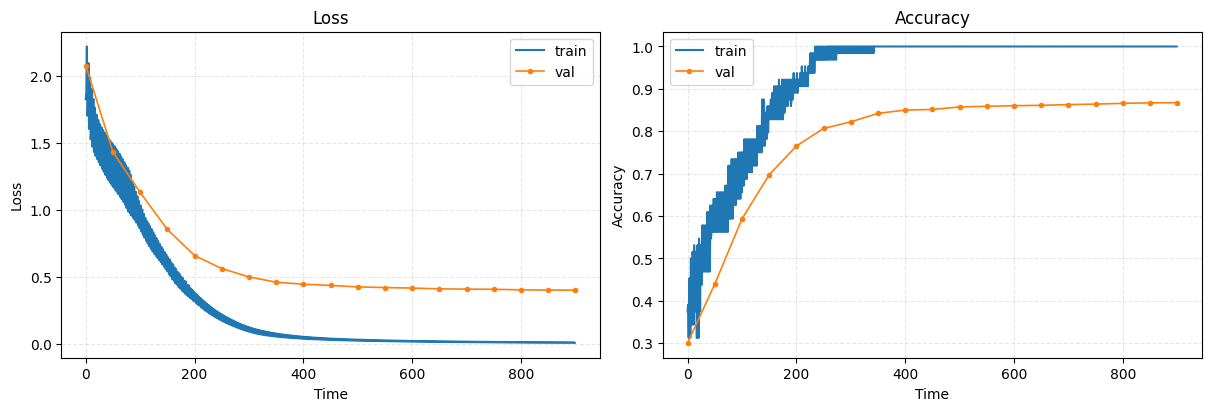

In [ ]:
plot_history(history)

In [ ]:
import torch, hashlib, json

def save_coop_prompt(coop_prompt: nn.Module, path: str, *,
                     model_name: str, pretrained: str, classnames: list, n_ctx: int):
    # minimal payload: the ctx tensor + metadata to sanity-check at load time
    payload = {
        "ctx": coop_prompt.ctx.detach().cpu(),  # device-agnostic
        "meta": {
            "model_name": model_name,
            "pretrained": pretrained,
            "n_ctx": int(n_ctx),
            "classnames": list(classnames),
            # quick fingerprint to catch class order changes
            "classnames_sha1": hashlib.sha1(
                json.dumps(list(classnames), ensure_ascii=False).encode("utf-8")
            ).hexdigest(),
        }
    }
    torch.save(payload, path)


In [ ]:
save_coop_prompt(coopclip_model.coop_prompt, cfg.coop_prompt_save_path,
                 model_name=cfg.model_name, pretrained=cfg.pretrained,
                 classnames=classnames, n_ctx=cfg.prompt_len)

In [ ]:
def load_coop_prompt(clip: nn.Module, tokenizer, path: str):
  payload = torch.load(path)
  ctx = payload["ctx"]
  n_ctx = payload["meta"]["n_ctx"]
  classnames = payload["meta"]["classnames"]
  model_name = payload["meta"]["model_name"]
  if cfg.model_name != model_name:
    raise ValueError(f"Model from path: '{model_name}' doesn't match the cfg.modelname: '{cfg.model_name}'")
  coop_prompt = CoOpPrompt(clip, tokenizer, classnames, n_ctx)
  with torch.no_grad():
    coop_prompt.ctx.copy_(ctx)

  return coop_prompt

In [ ]:
loaded_prompt = load_coop_prompt(clip_model, tokenizer, cfg.coop_prompt_save_path)

In [ ]:
loaded_coopclip_model = CoOpClip(
    clip=clip_model,
    coop_prompt=loaded_prompt,
).to(device)

loss, acc = evaluate_classifier(
    model=loaded_coopclip_model,
    test_loader=val_loader,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    desc="Testing CoOpClip on full val",
    pbar=True
)
print(f"Accuracy for loaded model: {acc}")

Testing CoOpClip on full val:   0%|          | 0/43 [00:00<?, ?it/s]

Accuracy for loaded model: 0.8674074074074074


In [ ]:
from PIL import Image
image = Image.open("floare_teo4.jpg")
plt.imshow(image)
logits = coopclip_model(preprocess(image).unsqueeze(0))
pred = logits.argmax(1)
pred_class = classnames[pred]
print(f"The image is a {pred_class}")

In [ ]:
#coop, history = train_coop(
#    model=model,
#    tokenizer=tokenizer,
#    classnames=classnames,
#    train_loader=train_loader,
#    val_loader=val_loader,
#    device=device,
#    n_ctx=cfg.prompt_len,
#    epochs=cfg.max_epochs,
#    batch_size=cfg.batch_size,
#    lr=cfg.lr_prompt,
#    num_workers=cfg.num_workers,
#)

In [ ]:
# 10) Extra analysis: (optional) confusion matrix if sklearn is available
try:
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in tqdm(val_loader, leave=False, desc='cm'):
            p = coopclip_model(x.to(device)).argmax(dim=1).cpu()
            y_true.extend(y.cpu().tolist())
            y_pred.extend(p.tolist())
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=classnames)
    fig, ax = plt.subplots(figsize=(8,8))
    disp.plot(ax=ax, include_values=False, xticks_rotation=90, cmap='Blues')
    plt.title('Confusion Matrix (test)')
    plt.tight_layout(); plt.show()
except Exception as e:
    print('Install scikit-learn to see confusion matrix. Skipping. Error:', e)